# 🧠 State-of-the-Art Brain MRI Segmentation

**A comprehensive deep learning pipeline for brain MRI segmentation (FLAIR/BraTS2020)**

### Key Features:
- ✅ **UNet++ with Attention** + EfficientNet-B3 encoder (excellent for medical segmentation, handles intensity variation well)
- ✅ **Max pooling mask downsampling** (preserves small lesion regions!)
- ✅ **SMP's DiceLoss + BCE hybrid** (well-tested implementation)
- ✅ **256×256 resolution** (optimized for RTX 4060)
- ✅ **Brain MRI-friendly augmentations** (flips, rotations - unlike chest X-rays)
- ⭐ **Kaggle winner tricks**: Class rebalancing, optimal threshold, TTA
- ✅ **Early stopping** with patience monitoring
- ✅ **Mixed precision training** for speed

**Target: Dice Coefficient > 0.85**

**Optimized for RTX 4060 Laptop GPU (8GB VRAM)**

In [1]:
# Install dependencies if needed (uncomment if required)
# !pip install segmentation-models-pytorch albumentations opencv-python-headless

# ⚠️ IMPORTANT: If you see HuggingFace progress bar errors, RESTART THE KERNEL and run cells in order!

In [2]:
import os

# ⚠️ IMPORTANT: Set these BEFORE any other imports to fix HuggingFace progress bar errors
# If you see progress bar errors, RESTART THE KERNEL and run this cell first!
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Tuple, Optional, Dict, List
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split, StratifiedKFold
from concurrent.futures import ThreadPoolExecutor
import torchvision.io

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.2 GB


In [ ]:
class Config:
    """Training configuration - adjust for your hardware and dataset."""
    
    # === DATA PATHS ===
    # FLAIR dataset structure: brain/flair/flair/kaggle_3m/
    # Each patient has a folder with images and masks: {patient_id}_{slice}.tif and {patient_id}_{slice}_mask.tif
    DATA_ROOT = "brain/flair/FLAIR/kaggle_3m"  # Root directory containing patient folders
    OUTPUT_DIR = "brain_mri_output"
    
    # === MODEL SETTINGS ===
    ENCODER = "efficientnet-b3"     # EfficientNet-B3: Excellent for medical segmentation, handles intensity variation well     # NOTE: if convnext tiny comes out for this in the future, use that
    ENCODER_WEIGHTS = "imagenet"
    ATTENTION_TYPE = "scse"          # Spatial + Channel attention
    
    # === IMAGE SETTINGS ===
    IMAGE_SIZE = 256                 # 256x256 for RTX 4060 (8GB)
    IN_CHANNELS = 1                  # 1 for grayscale FLAIR, 3 if converting to RGB
    USE_PATCHES = False              # Disabled: full image training works better
    
    # === TRAINING MODE ===
    USE_KFOLD = False                # False = Single Split (faster)
    N_FOLDS = 5
    VAL_SPLIT = 0.2
    
    # === TRAINING SETTINGS ===
    BATCH_SIZE = 20                  # RTX 4060 (8GB): 16 for 256x256
    GRADIENT_ACCUMULATION = 2        # Effective batch size = 32
    EPOCHS = 30
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # === LOSS FUNCTION ===
    LOSS_TYPE = 'bce_dice'           # 'bce_dice' or 'focal_dice'
    DICE_WEIGHT = 0.8                # λ parameter
    FOCAL_ALPHA = 0.9
    FOCAL_GAMMA = 2.0
    
    # === DROPOUT ===
    USE_DROPOUT = True
    DECODER_DROPOUT = 0.1
    
    # === EARLY STOPPING ===
    PATIENCE = 10
    
    # === HARDWARE ===
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 2
    MIXED_PRECISION = True
    
    SEED = 42

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("📋 Configuration:")
print(f"   Device: {config.DEVICE}")
print(f"   Encoder: {config.ENCODER}")
print(f"   Image Size: {config.IMAGE_SIZE}")
print(f"   Input Channels: {config.IN_CHANNELS}")
print(f"   Batch Size: {config.BATCH_SIZE} (effective: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION})")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Learning Rate: {config.LEARNING_RATE}")

# Set seeds
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config.SEED)


📋 Configuration:
   Device: cuda
   Encoder: efficientnet-b3
   Image Size: 256
   Input Channels: 1
   Batch Size: 20 (effective: 40)
   Epochs: 30
   Learning Rate: 0.0001


In [ ]:
# Loss Functions - Using SMP's well-tested implementations
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
bce_loss = nn.BCEWithLogitsLoss()

class DiceBCELoss(nn.Module):
    """Standard formulation: L = BCE + λ * Dice"""
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        return self.bce_loss(pred, target) + self.dice_weight * self.dice_loss(pred, target)

class FocalLoss(nn.Module):
    """Focal Loss for handling extreme class imbalance."""
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=True):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits
    
    def forward(self, pred, target):
        if self.from_logits:
            pred_prob = torch.sigmoid(pred)
        else:
            pred_prob = pred
        
        with torch.cuda.amp.autocast(enabled=False):
            bce = nn.functional.binary_cross_entropy(
                pred_prob.float(), target.float(), reduction='none'
            )
        
        p_t = pred_prob * target + (1 - pred_prob) * (1 - target)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
        focal_loss = alpha_t * focal_weight * bce
        return focal_loss.mean()

class DiceFocalLoss(nn.Module):
    """Standard formulation: L = Focal + λ * Dice"""
    def __init__(self, dice_weight=0.5, focal_alpha=0.25, focal_gamma=2.0):
        super().__init__()
        self.dice_weight = dice_weight
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, from_logits=True)
    
    def forward(self, pred, target):
        return self.focal_loss(pred, target) + self.dice_weight * self.dice_loss(pred, target)

# Augmentation Pipelines - Brain MRI can handle more aggressive augmentations!
def get_training_augmentation(image_size=256):
    """Brain MRI-friendly augmentations: flips, rotations, elastic transforms."""
    return A.Compose([
        # A.HorizontalFlip(p=0.5),  # ✅ Brain MRI can be flipped!      commented coz questionable
        A.VerticalFlip(p=0.5),    # ✅ Brain MRI can be flipped vertically too!
        A.Rotate(limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.7),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        # A.Normalize(
        #     mean=(0.485, 0.456, 0.406) if config.IN_CHANNELS == 3 else (0.5,),
        #     std=(0.229, 0.224, 0.225) if config.IN_CHANNELS == 3 else (0.5,)
        # ),
                # grayscale normalization
        A.Normalize(
            mean=(0.5,0.5,0.5),
            std=(0.5,0.5,0.5)
        ),
        ToTensorV2()
    ])

def get_validation_augmentation():
    return A.Compose([
        # A.Normalize(
        #     mean=(0.485, 0.456, 0.406) if config.IN_CHANNELS == 3 else (0.5,),
        #     std=(0.229, 0.224, 0.225) if config.IN_CHANNELS == 3 else (0.5,)
        # ),
        # grayscale normalization
        A.Normalize(
            mean=(0.5,0.5,0.5),
            std=(0.5,0.5,0.5)
        ),
        ToTensorV2()
    ])

# Metrics - Per-sample calculation then average
def dice_coefficient(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Dice per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate IoU per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def f1_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate F1 Score."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1.mean()

def precision_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Precision per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))  # True Positives
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))  # False Positives
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision.mean()

def recall_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Recall (Sensitivity) per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))  # True Positives
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))  # False Negatives
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall.mean()

def accuracy_score(pred, target, threshold=0.5):
    """Calculate Accuracy per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    correct = (pred == target).float()
    accuracy = correct.sum(dim=(1, 2, 3)) / target.numel() * target.size(0)  # Normalize by spatial size
    return accuracy.mean()

print("✅ Loss functions and augmentations defined")


✅ Loss functions and augmentations defined


In [5]:
class BrainMRIDataset(Dataset):
    """Dataset for FLAIR brain MRI with MAX POOLING for mask downsampling."""
    
    def __init__(self, image_mask_pairs, transform=None, 
                 image_size=256, is_training=True, in_channels=1):
        """
        Args:
            image_mask_pairs: List of tuples (image_path, mask_path)
            transform: Albumentations transform
            image_size: Target image size
            is_training: Whether this is training data
            in_channels: 1 for grayscale, 3 for RGB
        """
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform
        self.image_size = image_size
        self.is_training = is_training
        self.in_channels = in_channels
    
    def __len__(self):
        return len(self.image_mask_pairs)
    
    def _max_pool_downsample_mask(self, mask, target_size):
        """Use max pooling to preserve small lesion regions during downsampling."""
        h, w = mask.shape
        if h == target_size and w == target_size:
            return mask
        
        ratio = h // target_size
        if ratio > 1 and h % target_size == 0 and w % target_size == 0:
            mask_reshaped = mask.reshape(target_size, ratio, target_size, ratio)
            mask_downsampled = mask_reshaped.max(axis=(1, 3))
            return mask_downsampled
        else:
            return cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
    
    def __getitem__(self, idx):
        image_path, mask_path = self.image_mask_pairs[idx]
        
        # Load .tif files (FLAIR dataset uses TIF format)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")
        if mask is None:
            # Create empty mask if mask file doesn't exist
            mask = np.zeros_like(image)
        
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = self._max_pool_downsample_mask(mask, self.image_size)
        mask = (mask > 0).astype(np.float32)
        
        if self.in_channels == 1:
            image = np.expand_dims(image, axis=-1)
        elif self.in_channels == 3:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        mask = np.expand_dims(mask, axis=-1)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        
        if mask.dim() == 3:
            mask = mask.permute(2, 0, 1)
        else:
            mask = mask.unsqueeze(0)
        
        return image, mask

print("✅ Dataset class defined")


✅ Dataset class defined


In [6]:
# Load FLAIR dataset: Find all image-mask pairs
# Structure: brain/flair/flair/kaggle_3m/{patient_folder}/{patient_id}_{slice}.tif and {patient_id}_{slice}_mask.tif

def find_flair_image_mask_pairs(data_root):
    """
    Find all image-mask pairs in the FLAIR dataset.
    Returns list of (image_path, mask_path) tuples.
    """
    image_mask_pairs = []
    
    if not os.path.exists(data_root):
        print(f"⚠️ Data root not found: {data_root}")
        return image_mask_pairs
    
    # Get all patient folders
    patient_folders = [d for d in os.listdir(data_root) 
                       if os.path.isdir(os.path.join(data_root, d)) and d.startswith('TCGA_')]
    
    print(f"📁 Found {len(patient_folders)} patient folders")
    
    for patient_folder in tqdm(patient_folders, desc="Scanning patient folders"):
        patient_path = os.path.join(data_root, patient_folder)
        
        # Get all .tif files in this patient folder
        all_tif_files = [f for f in os.listdir(patient_path) if f.lower().endswith('.tif')]
        
        # Separate images and masks
        image_files = [f for f in all_tif_files if not f.endswith('_mask.tif')]
        
        for img_file in image_files:
            # Construct mask filename: {base}_mask.tif
            base_name = img_file.replace('.tif', '')
            mask_file = f"{base_name}_mask.tif"
            
            image_path = os.path.join(patient_path, img_file)
            mask_path = os.path.join(patient_path, mask_file)
            
            # Check if both files exist
            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_mask_pairs.append((image_path, mask_path))
    
    return image_mask_pairs

def validate_image_mask_pair(image_path, mask_path):
    """Validate a single image/mask pair."""
    try:
        # Try to load with OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            return None, None, image_path
        
        h, w = img.shape
        img_mean = img.mean()
        mask_max = mask.max()
        
        # Basic validation: reasonable size and non-zero mean
        if h > 50 and w > 50 and img_mean > 5:
            return (image_path, mask_path), 1 if mask_max > 0 else 0, None
        else:
            return None, None, image_path
    except Exception as e:
        return None, None, image_path

# Find all image-mask pairs
print(f"🔍 Scanning FLAIR dataset in: {config.DATA_ROOT}")
all_pairs = find_flair_image_mask_pairs(config.DATA_ROOT)

if len(all_pairs) > 0:
    print(f"\n📊 Found {len(all_pairs)} image-mask pairs")
    
    # Validate all pairs
    print("🔍 Validating image-mask pairs...")
    valid_pairs = []
    has_lesion = []
    corrupted_files = []
    
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(validate_image_mask_pair, img_path, mask_path) 
                   for img_path, mask_path in all_pairs]
        for f in tqdm(futures, desc="Validating"):
            try:
                pair, lesion, corrupt = f.result()
                if pair is not None:
                    valid_pairs.append(pair)
                    has_lesion.append(lesion)
                elif corrupt:
                    corrupted_files.append(corrupt)
            except Exception:
                continue
    
    has_lesion = np.array(has_lesion)
    
    print(f"\n📊 Data Summary:")
    print(f"   Total pairs found: {len(all_pairs)}")
    print(f"   Valid pairs: {len(valid_pairs)}")
    if corrupted_files:
        print(f"   ⚠️ Filtered out: {len(corrupted_files)} corrupted/invalid pairs")
    print(f"\n📊 Class distribution:")
    print(f"   With lesions: {has_lesion.sum()} ({100*has_lesion.mean():.1f}%)")
    print(f"   Without: {len(has_lesion) - has_lesion.sum()} ({100*(1-has_lesion.mean()):.1f}%)")
else:
    print(f"⚠️ No image-mask pairs found in {config.DATA_ROOT}")
    print("   Please check the data path in config.DATA_ROOT")
    valid_pairs = []
    has_lesion = np.array([])


🔍 Scanning FLAIR dataset in: brain/flair/FLAIR/kaggle_3m
📁 Found 110 patient folders


Scanning patient folders:   0%|          | 0/110 [00:00<?, ?it/s]


📊 Found 3929 image-mask pairs
🔍 Validating image-mask pairs...


Validating:   0%|          | 0/3929 [00:00<?, ?it/s]


📊 Data Summary:
   Total pairs found: 3929
   Valid pairs: 3745
   ⚠️ Filtered out: 184 corrupted/invalid pairs

📊 Class distribution:
   With lesions: 1373 (36.7%)
   Without: 2372 (63.3%)


---
## 4.5. Exploratory Data Analysis (EDA) 📊

**Visualize samples from all classes to understand the dataset**


📊 Exploratory Data Analysis
   Total samples: 3745
   With lesions: 1373 (36.7%)
   Without lesions: 2372 (63.3%)

   Showing 5 samples from each class...



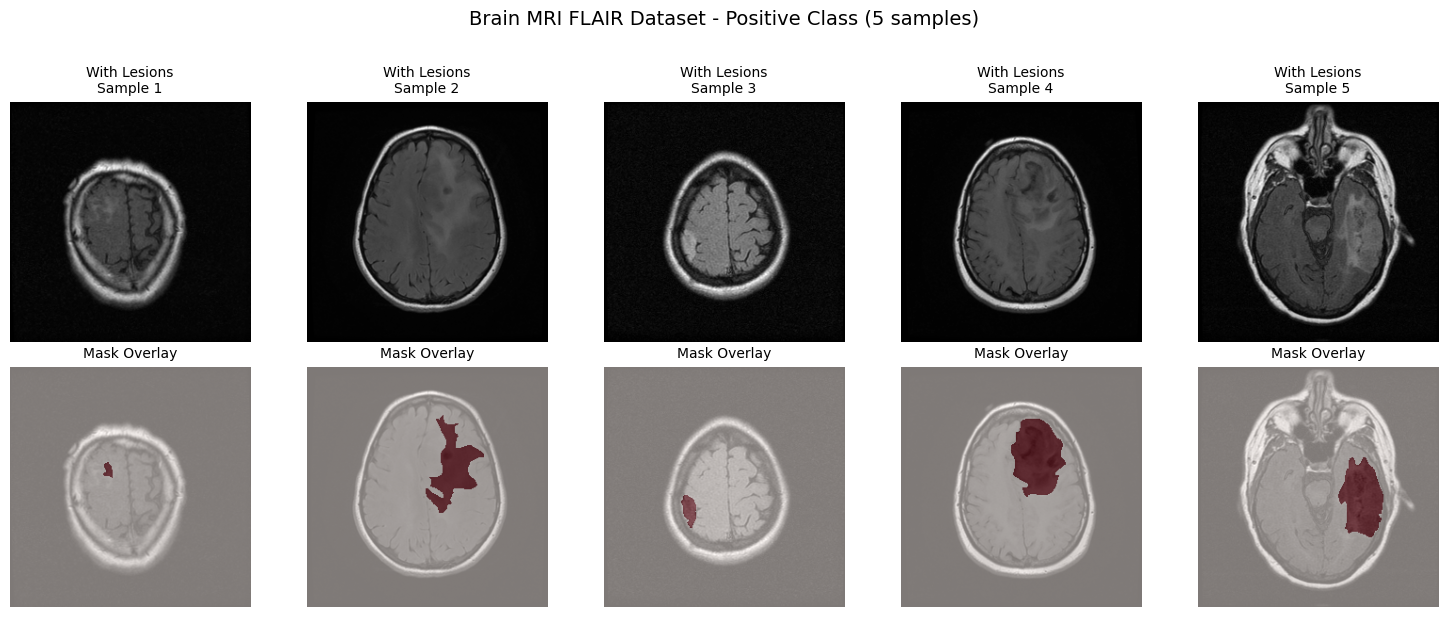

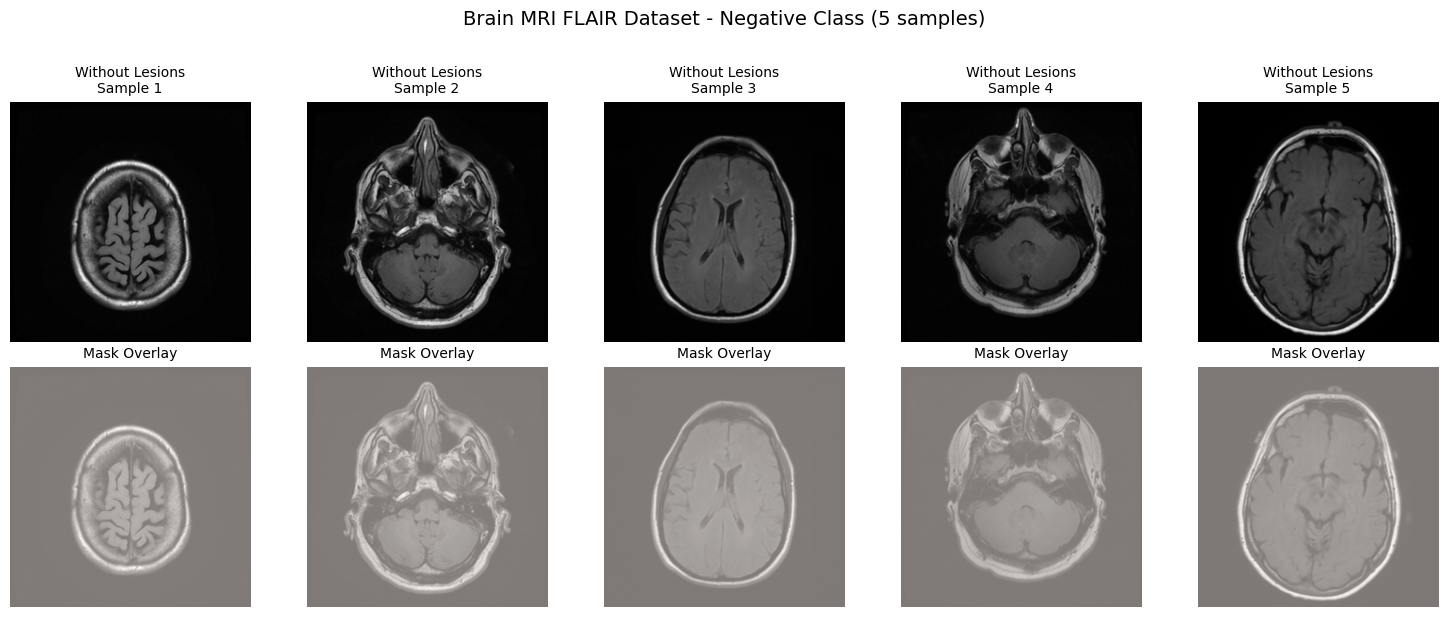

In [7]:
# EDA: Visualize samples from all classes
def visualize_samples_by_class(dataset, image_mask_pairs, has_lesion, n_samples=5, title="Dataset Samples"):
    """
    Visualize n samples from each class (with and without lesions).
    
    Args:
        dataset: Dataset object
        image_mask_pairs: List of (image_path, mask_path) tuples
        has_lesion: Array indicating which samples have lesions
        n_samples: Number of samples to show per class
        title: Title for the plot
    """
    # Get indices for each class
    positive_indices = np.where(has_lesion == 1)[0]
    negative_indices = np.where(has_lesion == 0)[0]
    
    # Sample n_samples from each class
    np.random.seed(config.SEED)
    if len(positive_indices) >= n_samples:
        pos_samples = np.random.choice(positive_indices, n_samples, replace=False)
    else:
        pos_samples = positive_indices
    
    if len(negative_indices) >= n_samples:
        neg_samples = np.random.choice(negative_indices, n_samples, replace=False)
    else:
        neg_samples = negative_indices
    
    # Create figure: 2 rows (positive/negative) x n_samples columns x 2 (image/mask)
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 6))
    if n_samples == 1:
        axes = axes.reshape(2, 1)
    
    # Plot positive class (with lesions)
    for i, idx in enumerate(pos_samples):
        if idx < len(dataset):
            image, mask = dataset[idx]
            
            # Denormalize image
            if config.IN_CHANNELS == 1:
                img = image.squeeze().numpy()
                img = (img * 0.5) + 0.5  # Denormalize
            else:
                img = image.permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            mask_np = mask.squeeze().numpy()
            
            axes[0, i].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes[0, i].set_title(f'With Lesions\nSample {i+1}', fontsize=10)
            axes[0, i].axis('off')
            
            # Overlay mask on image
            axes[1, i].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes[1, i].imshow(mask_np, alpha=0.5, cmap='Reds')
            axes[1, i].set_title(f'Mask Overlay', fontsize=10)
            axes[1, i].axis('off')
    
    plt.suptitle(f'{title} - Positive Class ({n_samples} samples)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Also show negative class samples
    fig2, axes2 = plt.subplots(2, n_samples, figsize=(n_samples * 3, 6))
    if n_samples == 1:
        axes2 = axes2.reshape(2, 1)
    
    for i, idx in enumerate(neg_samples):
        if idx < len(dataset):
            image, mask = dataset[idx]
            
            # Denormalize image
            if config.IN_CHANNELS == 1:
                img = image.squeeze().numpy()
                img = (img * 0.5) + 0.5  # Denormalize
            else:
                img = image.permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            mask_np = mask.squeeze().numpy()
            
            axes2[0, i].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes2[0, i].set_title(f'Without Lesions\nSample {i+1}', fontsize=10)
            axes2[0, i].axis('off')
            
            axes2[1, i].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes2[1, i].imshow(mask_np, alpha=0.5, cmap='Reds')
            axes2[1, i].set_title(f'Mask Overlay', fontsize=10)
            axes2[1, i].axis('off')
    
    plt.suptitle(f'{title} - Negative Class ({n_samples} samples)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Create a dataset without augmentation for visualization
if len(valid_pairs) > 0:
    eda_dataset = BrainMRIDataset(
        valid_pairs,
        get_validation_augmentation(),  # Use validation augmentation (no random transforms)
        config.IMAGE_SIZE, is_training=False, in_channels=config.IN_CHANNELS
    )
    
    print("📊 Exploratory Data Analysis")
    print(f"   Total samples: {len(valid_pairs)}")
    print(f"   With lesions: {has_lesion.sum()} ({100*has_lesion.mean():.1f}%)")
    print(f"   Without lesions: {len(has_lesion) - has_lesion.sum()} ({100*(1-has_lesion.mean()):.1f}%)")
    print(f"\n   Showing {5} samples from each class...\n")
    
    visualize_samples_by_class(eda_dataset, valid_pairs, has_lesion, n_samples=5, title="Brain MRI FLAIR Dataset")
else:
    print("⚠️ No valid pairs available for EDA")


In [8]:
# Create train/val split and dataloaders
from torch.utils.data import WeightedRandomSampler

if len(valid_pairs) > 0:
    # Split image-mask pairs
    train_pairs, val_pairs = train_test_split(
        valid_pairs, test_size=config.VAL_SPLIT, 
        stratify=has_lesion if len(has_lesion) > 0 else None, 
        random_state=config.SEED
    )
    
    train_dataset = BrainMRIDataset(
        train_pairs,
        get_training_augmentation(config.IMAGE_SIZE), 
        config.IMAGE_SIZE, is_training=True, in_channels=config.IN_CHANNELS
    )
    val_dataset = BrainMRIDataset(
        val_pairs,
        get_validation_augmentation(), 
        config.IMAGE_SIZE, is_training=False, in_channels=config.IN_CHANNELS
    )
    
    # ⭐ Class Rebalancing (oversample positive cases)
    USE_CLASS_REBALANCING = True
    
    if USE_CLASS_REBALANCING and len(has_lesion) > 0:
        # Get lesion labels for training pairs
        train_indices = [valid_pairs.index(pair) for pair in train_pairs]
        train_has_lesion = has_lesion[train_indices]
        class_counts = np.bincount(train_has_lesion.astype(int))
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[train_has_lesion.astype(int)]
        
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(
            train_dataset, batch_size=config.BATCH_SIZE, sampler=sampler,
            num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
        )
        print(f"   ⭐ Class rebalancing enabled")
    else:
        train_loader = DataLoader(
            train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
            num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
        )
    
    val_loader = DataLoader(
        val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
        num_workers=config.NUM_WORKERS, pin_memory=True
    )
    
    print(f"\n📂 Data split: Train={len(train_pairs)}, Val={len(val_pairs)}")
    print(f"   Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
else:
    print("⚠️ No valid image-mask pairs found. Please check your data paths.")
    train_loader = None
    val_loader = None


   ⭐ Class rebalancing enabled

📂 Data split: Train=2996, Val=749
   Train batches: 149, Val batches: 38


In [9]:
# Create UNet++ model
model = smp.UnetPlusPlus(
    encoder_name=config.ENCODER, 
    encoder_weights=config.ENCODER_WEIGHTS,
    in_channels=config.IN_CHANNELS,
    classes=1, 
    activation=None, 
    decoder_attention_type=config.ATTENTION_TYPE,
    decoder_dropout=config.DECODER_DROPOUT if config.USE_DROPOUT else 0.0
)
model = model.to(config.DEVICE)

# Training setup - Loss function selection
if config.LOSS_TYPE == 'focal_dice':
    criterion = DiceFocalLoss(
        dice_weight=config.DICE_WEIGHT,
        focal_alpha=config.FOCAL_ALPHA,
        focal_gamma=config.FOCAL_GAMMA
    )
    loss_info = f"Focal + λ*Dice (λ={config.DICE_WEIGHT}, α={config.FOCAL_ALPHA}, γ={config.FOCAL_GAMMA})"
else:
    criterion = DiceBCELoss(dice_weight=config.DICE_WEIGHT)
    loss_info = f"BCE + λ*Dice (λ={config.DICE_WEIGHT}, standard formulation)"

optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-7)
scaler = GradScaler(enabled=config.MIXED_PRECISION)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🧠 Model: UNet++ with Attention ({config.ENCODER})")
print(f"   Parameters: {total_params:,}")
print(f"   Input Channels: {config.IN_CHANNELS}")
print(f"   Loss: {loss_info}")
print(f"   Dropout: {config.DECODER_DROPOUT if config.USE_DROPOUT else 'Disabled'} (decoder blocks)")
print(f"   Optimizer: AdamW (lr={config.LEARNING_RATE}, wd={config.WEIGHT_DECAY})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5, min_lr=1e-7)")



🧠 Model: UNet++ with Attention (efficientnet-b3)
   Parameters: 13,714,522
   Input Channels: 1
   Loss: BCE + λ*Dice (λ=1.0, standard formulation)
   Dropout: 0.1 (decoder blocks)
   Optimizer: AdamW (lr=0.0001, wd=1e-05)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5, min_lr=1e-7)


In [10]:
# Training history
history = {
    'train_loss': [], 'train_dice': [], 'train_f1': [],
    'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_f1': []
}
best_dice = 0.0
best_iou = 0.0
patience_counter = 0
best_model_path = None

print("=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)

if train_loader is not None and val_loader is not None:
    for epoch in range(config.EPOCHS):
        # === TRAINING ===
        model.train()
        train_loss, train_dice, train_f1 = 0.0, 0.0, 0.0
        optimizer.zero_grad()
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{config.EPOCHS}")
        for batch_idx, (images, masks) in pbar:
            images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images)
                loss = criterion(outputs, masks) / config.GRADIENT_ACCUMULATION
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % config.GRADIENT_ACCUMULATION == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * config.GRADIENT_ACCUMULATION * images.size(0)
            train_dice += dice_coefficient(outputs, masks).item() * images.size(0)
            train_f1 += f1_score(outputs, masks).item() * images.size(0)
            pbar.set_postfix({'loss': f'{loss.item()*config.GRADIENT_ACCUMULATION:.4f}'})
        
        train_loss /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)
        train_f1 /= len(train_loader.dataset)
        
        # === VALIDATION ===
        model.eval()
        val_loss, val_dice, val_iou, val_f1 = 0.0, 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                with autocast(enabled=config.MIXED_PRECISION):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_dice += dice_coefficient(outputs, masks).item() * images.size(0)
                val_iou += iou_score(outputs, masks).item() * images.size(0)
                val_f1 += f1_score(outputs, masks).item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        
        scheduler.step(val_dice)
        
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_f1'].append(val_f1)
        
        print(f"\n📊 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Dice={train_dice:.4f}, Train F1={train_f1:.4f}")
        print(f"   Val Loss={val_loss:.4f}, Val Dice={val_dice:.4f}, Val IoU={val_iou:.4f}, Val F1={val_f1:.4f}")
        
        if val_dice > best_dice:
            best_dice = val_dice
            best_iou = val_iou
            patience_counter = 0
            model_name = f"brain_mri_dice{val_dice:.4f}_iou{val_iou:.4f}_ep{epoch+1}.pth"
            best_model_path = os.path.join(config.OUTPUT_DIR, model_name)
            torch.save({
                'epoch': epoch, 'model_state_dict': model.state_dict(), 
                'val_dice': val_dice, 'val_iou': val_iou, 'history': history,
                'encoder': config.ENCODER, 'image_size': config.IMAGE_SIZE,
                'in_channels': config.IN_CHANNELS
            }, best_model_path)
            print(f"   ✅ New best model saved: {model_name}")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{config.PATIENCE})")
        
        if patience_counter >= config.PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

    print("\n" + "=" * 60)
    print(f"🎉 TRAINING COMPLETE! Best Dice: {best_dice:.4f}")
    print("=" * 60)
else:
    print("⚠️ Cannot start training: data loaders not initialized. Please check your data paths.")


🚀 STARTING TRAINING


Epoch 1/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 1: Train Loss=1.1128, Train Dice=0.0832, Train F1=0.0832
   Val Loss=1.0189, Val Dice=0.4307, Val IoU=0.4188, Val F1=0.4307
   ✅ New best model saved: brain_mri_dice0.4307_iou0.4188_ep1.pth


Epoch 2/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 2: Train Loss=0.8967, Train Dice=0.4038, Train F1=0.4038
   Val Loss=0.7748, Val Dice=0.7932, Val IoU=0.7504, Val F1=0.7932
   ✅ New best model saved: brain_mri_dice0.7932_iou0.7504_ep2.pth


Epoch 3/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 3: Train Loss=0.7271, Train Dice=0.6174, Train F1=0.6174
   Val Loss=0.6475, Val Dice=0.8118, Val IoU=0.7691, Val F1=0.8118
   ✅ New best model saved: brain_mri_dice0.8118_iou0.7691_ep3.pth


Epoch 4/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 4: Train Loss=0.5727, Train Dice=0.6733, Train F1=0.6733
   Val Loss=0.5769, Val Dice=0.8221, Val IoU=0.7899, Val F1=0.8221
   ✅ New best model saved: brain_mri_dice0.8221_iou0.7899_ep4.pth


Epoch 5/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 5: Train Loss=0.4790, Train Dice=0.7037, Train F1=0.7037
   Val Loss=0.3772, Val Dice=0.8560, Val IoU=0.8198, Val F1=0.8560
   ✅ New best model saved: brain_mri_dice0.8560_iou0.8198_ep5.pth


Epoch 6/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 6: Train Loss=0.3827, Train Dice=0.7371, Train F1=0.7371
   Val Loss=0.3330, Val Dice=0.7977, Val IoU=0.7563, Val F1=0.7977
   ⏳ No improvement (1/10)


Epoch 7/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 7: Train Loss=0.3549, Train Dice=0.7393, Train F1=0.7393
   Val Loss=0.2506, Val Dice=0.8603, Val IoU=0.8262, Val F1=0.8603
   ✅ New best model saved: brain_mri_dice0.8603_iou0.8262_ep7.pth


Epoch 8/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 8: Train Loss=0.3205, Train Dice=0.7490, Train F1=0.7490
   Val Loss=0.2250, Val Dice=0.8553, Val IoU=0.8204, Val F1=0.8553
   ⏳ No improvement (1/10)


Epoch 9/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 9: Train Loss=0.2980, Train Dice=0.7541, Train F1=0.7541
   Val Loss=0.2099, Val Dice=0.8616, Val IoU=0.8258, Val F1=0.8616
   ✅ New best model saved: brain_mri_dice0.8616_iou0.8258_ep9.pth


Epoch 10/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 10: Train Loss=0.2851, Train Dice=0.7654, Train F1=0.7654
   Val Loss=0.1806, Val Dice=0.8941, Val IoU=0.8625, Val F1=0.8941
   ✅ New best model saved: brain_mri_dice0.8941_iou0.8625_ep10.pth


Epoch 11/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 11: Train Loss=0.2776, Train Dice=0.7894, Train F1=0.7894
   Val Loss=0.1751, Val Dice=0.8855, Val IoU=0.8527, Val F1=0.8855
   ⏳ No improvement (1/10)


Epoch 12/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 12: Train Loss=0.2498, Train Dice=0.7818, Train F1=0.7818
   Val Loss=0.1688, Val Dice=0.8956, Val IoU=0.8644, Val F1=0.8956
   ✅ New best model saved: brain_mri_dice0.8956_iou0.8644_ep12.pth


Epoch 13/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 13: Train Loss=0.2625, Train Dice=0.7803, Train F1=0.7803
   Val Loss=0.1678, Val Dice=0.8748, Val IoU=0.8419, Val F1=0.8748
   ⏳ No improvement (1/10)


Epoch 14/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 14: Train Loss=0.2405, Train Dice=0.7817, Train F1=0.7817
   Val Loss=0.1612, Val Dice=0.8911, Val IoU=0.8585, Val F1=0.8911
   ⏳ No improvement (2/10)


Epoch 15/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 15: Train Loss=0.2418, Train Dice=0.7889, Train F1=0.7889
   Val Loss=0.1571, Val Dice=0.8908, Val IoU=0.8606, Val F1=0.8908
   ⏳ No improvement (3/10)


Epoch 16/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 16: Train Loss=0.2312, Train Dice=0.7957, Train F1=0.7957
   Val Loss=0.1505, Val Dice=0.8967, Val IoU=0.8655, Val F1=0.8967
   ✅ New best model saved: brain_mri_dice0.8967_iou0.8655_ep16.pth


Epoch 17/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 17: Train Loss=0.2488, Train Dice=0.7762, Train F1=0.7762
   Val Loss=0.1470, Val Dice=0.8951, Val IoU=0.8639, Val F1=0.8951
   ⏳ No improvement (1/10)


Epoch 18/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 18: Train Loss=0.2350, Train Dice=0.7928, Train F1=0.7928
   Val Loss=0.1676, Val Dice=0.8718, Val IoU=0.8383, Val F1=0.8718
   ⏳ No improvement (2/10)


Epoch 19/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 19: Train Loss=0.2286, Train Dice=0.8008, Train F1=0.8008
   Val Loss=0.1457, Val Dice=0.8931, Val IoU=0.8614, Val F1=0.8931
   ⏳ No improvement (3/10)


Epoch 20/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 20: Train Loss=0.2181, Train Dice=0.8114, Train F1=0.8114
   Val Loss=0.1472, Val Dice=0.8949, Val IoU=0.8632, Val F1=0.8949
   ⏳ No improvement (4/10)


Epoch 21/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 21: Train Loss=0.2285, Train Dice=0.7925, Train F1=0.7925
   Val Loss=0.1446, Val Dice=0.8934, Val IoU=0.8624, Val F1=0.8934
   ⏳ No improvement (5/10)


Epoch 22/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 22: Train Loss=0.2417, Train Dice=0.8070, Train F1=0.8070
   Val Loss=0.1413, Val Dice=0.8916, Val IoU=0.8601, Val F1=0.8916
   ⏳ No improvement (6/10)


Epoch 23/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 23: Train Loss=0.2099, Train Dice=0.8139, Train F1=0.8139
   Val Loss=0.1391, Val Dice=0.9047, Val IoU=0.8736, Val F1=0.9047
   ✅ New best model saved: brain_mri_dice0.9047_iou0.8736_ep23.pth


Epoch 24/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 24: Train Loss=0.2140, Train Dice=0.8130, Train F1=0.8130
   Val Loss=0.1380, Val Dice=0.9033, Val IoU=0.8728, Val F1=0.9033
   ⏳ No improvement (1/10)


Epoch 25/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 25: Train Loss=0.2076, Train Dice=0.8155, Train F1=0.8155
   Val Loss=0.1388, Val Dice=0.8980, Val IoU=0.8669, Val F1=0.8980
   ⏳ No improvement (2/10)


Epoch 26/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 26: Train Loss=0.2030, Train Dice=0.8217, Train F1=0.8217
   Val Loss=0.1374, Val Dice=0.9047, Val IoU=0.8740, Val F1=0.9047
   ✅ New best model saved: brain_mri_dice0.9047_iou0.8740_ep26.pth


Epoch 27/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 27: Train Loss=0.1995, Train Dice=0.8127, Train F1=0.8127
   Val Loss=0.1402, Val Dice=0.8802, Val IoU=0.8481, Val F1=0.8802
   ⏳ No improvement (1/10)


Epoch 28/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 28: Train Loss=0.2003, Train Dice=0.8160, Train F1=0.8160
   Val Loss=0.1384, Val Dice=0.9010, Val IoU=0.8694, Val F1=0.9010
   ⏳ No improvement (2/10)


Epoch 29/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 29: Train Loss=0.1987, Train Dice=0.8164, Train F1=0.8164
   Val Loss=0.1374, Val Dice=0.9042, Val IoU=0.8735, Val F1=0.9042
   ⏳ No improvement (3/10)


Epoch 30/30:   0%|          | 0/149 [00:00<?, ?it/s]


📊 Epoch 30: Train Loss=0.2051, Train Dice=0.8244, Train F1=0.8244
   Val Loss=0.1354, Val Dice=0.9047, Val IoU=0.8734, Val F1=0.9047
   ✅ New best model saved: brain_mri_dice0.9047_iou0.8734_ep30.pth

🎉 TRAINING COMPLETE! Best Dice: 0.9047


In [11]:
# This cell is now integrated into cell 4 (loss functions)
# Keeping this cell for backward compatibility or can be removed
pass


In [12]:
# This cell is now integrated into cell 8 (model setup)
# Keeping this cell for backward compatibility or can be removed
pass


In [13]:
# Training loop is now in cell 9
# This cell can be used for post-training analysis, optimal threshold finding, TTA, etc.

# Memory cleanup before threshold finding
torch.cuda.empty_cache()
if 'optimizer' in locals():
    del optimizer, scaler, scheduler
import gc
gc.collect()

# Find optimal threshold
def find_optimal_threshold(model, val_loader, device, search_range=(0.3, 0.7, 0.05)):
    """Find threshold that maximizes Dice coefficient on validation set."""
    model.eval()
    
    best_threshold = 0.5
    best_dice = 0.0
    
    print(f"🎯 Searching for optimal threshold in range {search_range[0]:.2f}-{search_range[1]:.2f}...")
    thresholds = np.arange(search_range[0], search_range[1], search_range[2])
    
    for threshold in thresholds:
        total_dice = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = torch.sigmoid(model(images))
                pred_binary = (outputs > threshold).float()
                batch_dice = dice_coefficient(pred_binary, masks, threshold=0.5).item()
                total_dice += batch_dice
                num_batches += 1
        
        dice = total_dice / num_batches if num_batches > 0 else 0.0
        
        if dice > best_dice:
            best_dice = dice
            best_threshold = threshold
        print(f"   Threshold {threshold:.2f}: Dice = {dice:.4f}")
    
    print(f"\n✅ Optimal threshold: {best_threshold:.2f} (Dice: {best_dice:.4f})")
    return best_threshold, best_dice

# Find optimal threshold if training completed
if best_model_path and os.path.exists(best_model_path) and val_loader is not None:
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimal_threshold, optimal_dice = find_optimal_threshold(model, val_loader, config.DEVICE)
else:
    optimal_threshold = 0.5
    print("⚠️ No trained model found, using default threshold=0.5")


🎯 Searching for optimal threshold in range 0.30-0.70...
   Threshold 0.30: Dice = 0.9004
   Threshold 0.35: Dice = 0.9005
   Threshold 0.40: Dice = 0.9006
   Threshold 0.45: Dice = 0.9032
   Threshold 0.50: Dice = 0.9044
   Threshold 0.55: Dice = 0.9042
   Threshold 0.60: Dice = 0.9053
   Threshold 0.65: Dice = 0.9051

✅ Optimal threshold: 0.60 (Dice: 0.9053)


In [14]:
# Test-Time Augmentation (TTA)
def predict_with_tta(model, image, device, threshold=0.5):
    """Apply TTA for more robust predictions."""
    model.eval()
    with torch.no_grad():
        # Original
        pred1 = torch.sigmoid(model(image.unsqueeze(0).to(device)))
        
        # Horizontal flip
        flip_dim = 2 if image.dim() == 3 else 1
        image_hflip = torch.flip(image, [flip_dim])
        pred2 = torch.sigmoid(model(image_hflip.unsqueeze(0).to(device)))
        pred2 = torch.flip(pred2, [3] if pred2.dim() == 4 else [2])
        
        # Vertical flip
        image_vflip = torch.flip(image, [1] if image.dim() == 3 else [0])
        pred3 = torch.sigmoid(model(image_vflip.unsqueeze(0).to(device)))
        pred3 = torch.flip(pred3, [2] if pred3.dim() == 4 else [1])
        
        # Average predictions
        pred_avg = (pred1 + pred2 + pred3) / 3
    
    pred_binary = (pred_avg > threshold).float()
    return pred_avg.squeeze().cpu().numpy(), pred_binary.squeeze().cpu().numpy()

print("✅ TTA function defined")


✅ TTA function defined


## 6. Comprehensive Evaluation 📊


In [17]:
def comprehensive_evaluate(model, data_loader, device, split_name="Evaluation", threshold=0.5):
    """
    Comprehensive evaluation with all metrics: Dice, IoU, F1, Precision, Recall, Accuracy.
    
    Args:
        model: Trained model
        data_loader: DataLoader for the dataset to evaluate
        device: Device to run evaluation on
        split_name: Name of the split (e.g., "Validation", "Test")
        threshold: Threshold for binary predictions
    
    Returns:
        Dictionary with all metrics
    """
    model.eval()
    all_metrics = {
        'loss': 0.0,
        'dice': 0.0,
        'iou': 0.0,
        'f1': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    
    total_samples = 0
    
    print(f"\n{'='*60}")
    print(f"📊 {split_name.upper()} EVALUATION")
    print(f"{'='*60}")
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc=f"Evaluating {split_name}")
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            batch_size = images.size(0)
            total_samples += batch_size
            
            # Calculate all metrics
            all_metrics['loss'] += loss.item() * batch_size
            all_metrics['dice'] += dice_coefficient(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['iou'] += iou_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['f1'] += f1_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['precision'] += precision_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['recall'] += recall_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['accuracy'] += accuracy_score(outputs, masks, threshold=threshold).item() * batch_size
    
    # Average over all samples
    for key in all_metrics:
        all_metrics[key] /= total_samples
    
    # Print results
    print(f"\n📈 Results (threshold={threshold}):")
    print(f"   Loss:      {all_metrics['loss']:.4f}")
    print(f"   Dice:      {all_metrics['dice']:.4f}")
    print(f"   IoU:       {all_metrics['iou']:.4f}")
    print(f"   F1 Score:  {all_metrics['f1']:.4f}")
    print(f"   Precision: {all_metrics['precision']:.4f}")
    print(f"   Recall:    {all_metrics['recall']:.4f}")
    print(f"   Accuracy:  {all_metrics['accuracy']:.4f}")
    print(f"{'='*60}\n")
    
    return all_metrics

# Evaluate on validation set
if 'best_model_path' in locals() and best_model_path and os.path.exists(best_model_path):
    print("🔍 Loading best model for evaluation...")
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Use optimal threshold if available, otherwise use 0.5
    eval_threshold = optimal_threshold if 'optimal_threshold' in locals() else 0.5
    
    val_metrics = comprehensive_evaluate(model, val_loader, config.DEVICE, 
                                         split_name="Validation", threshold=eval_threshold)
    
    # If test set exists, evaluate on it too
    if 'test_loader' in locals() and test_loader is not None:
        test_metrics = comprehensive_evaluate(model, test_loader, config.DEVICE,
                                             split_name="Test", threshold=eval_threshold)
else:
    print("⚠️ No trained model found. Run training cells first!")


🔍 Loading best model for evaluation...

📊 VALIDATION EVALUATION


Evaluating Validation:   0%|          | 0/38 [00:00<?, ?it/s]

NameError: name 'precision_score' is not defined

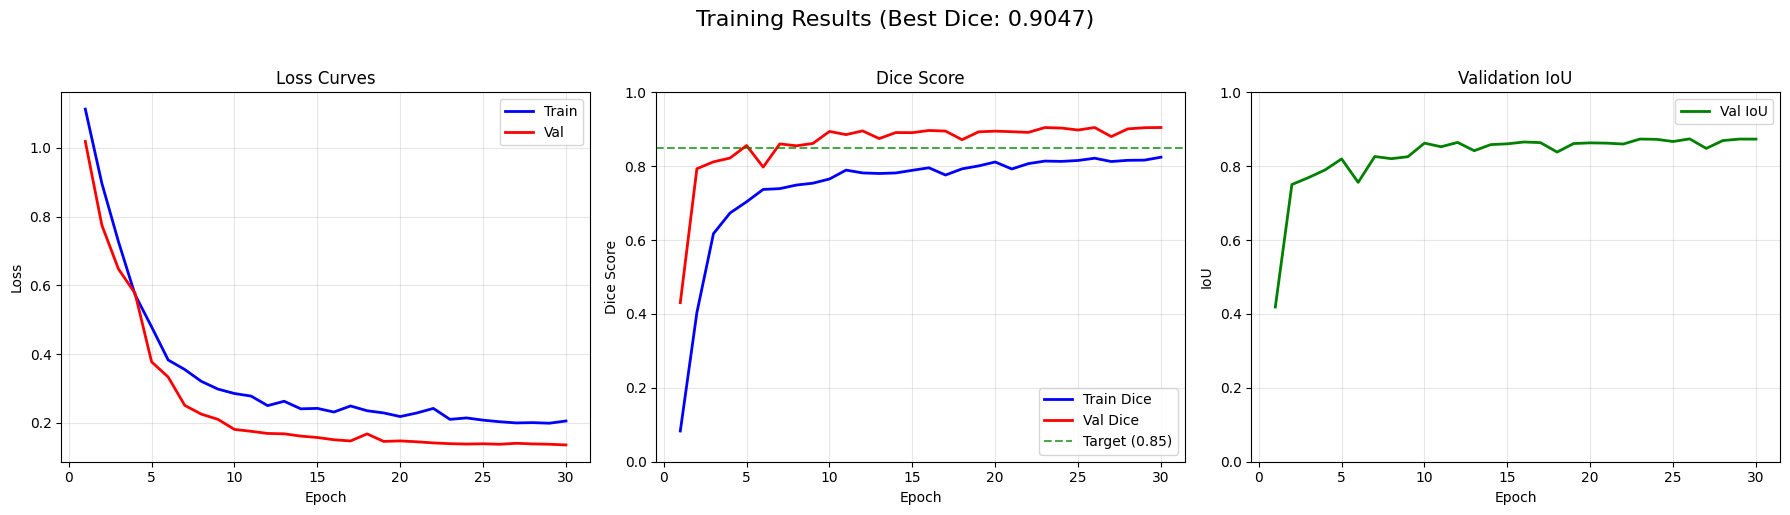

In [15]:
# Plot training curves
if history and len(history.get('train_loss', [])) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss Curves')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    axes[1].plot(epochs, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    axes[1].axhline(y=0.85, color='green', linestyle='--', label='Target (0.85)', alpha=0.7)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Dice Score'); axes[1].set_title('Dice Score')
    axes[1].legend(); axes[1].grid(True, alpha=0.3); axes[1].set_ylim(0, 1)

    axes[2].plot(epochs, history['val_iou'], 'g-', label='Val IoU', linewidth=2)
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('IoU'); axes[2].set_title('Validation IoU')
    axes[2].legend(); axes[2].grid(True, alpha=0.3); axes[2].set_ylim(0, 1)

    plt.suptitle(f'Training Results (Best Dice: {best_dice:.4f})', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No training history to plot")


✅ Loaded best model: brain_mri_dice0.9047_iou0.8734_ep30.pth
   Dice: 0.9047, IoU: 0.8733937207942652

🎯 Using threshold: 0.60 for predictions


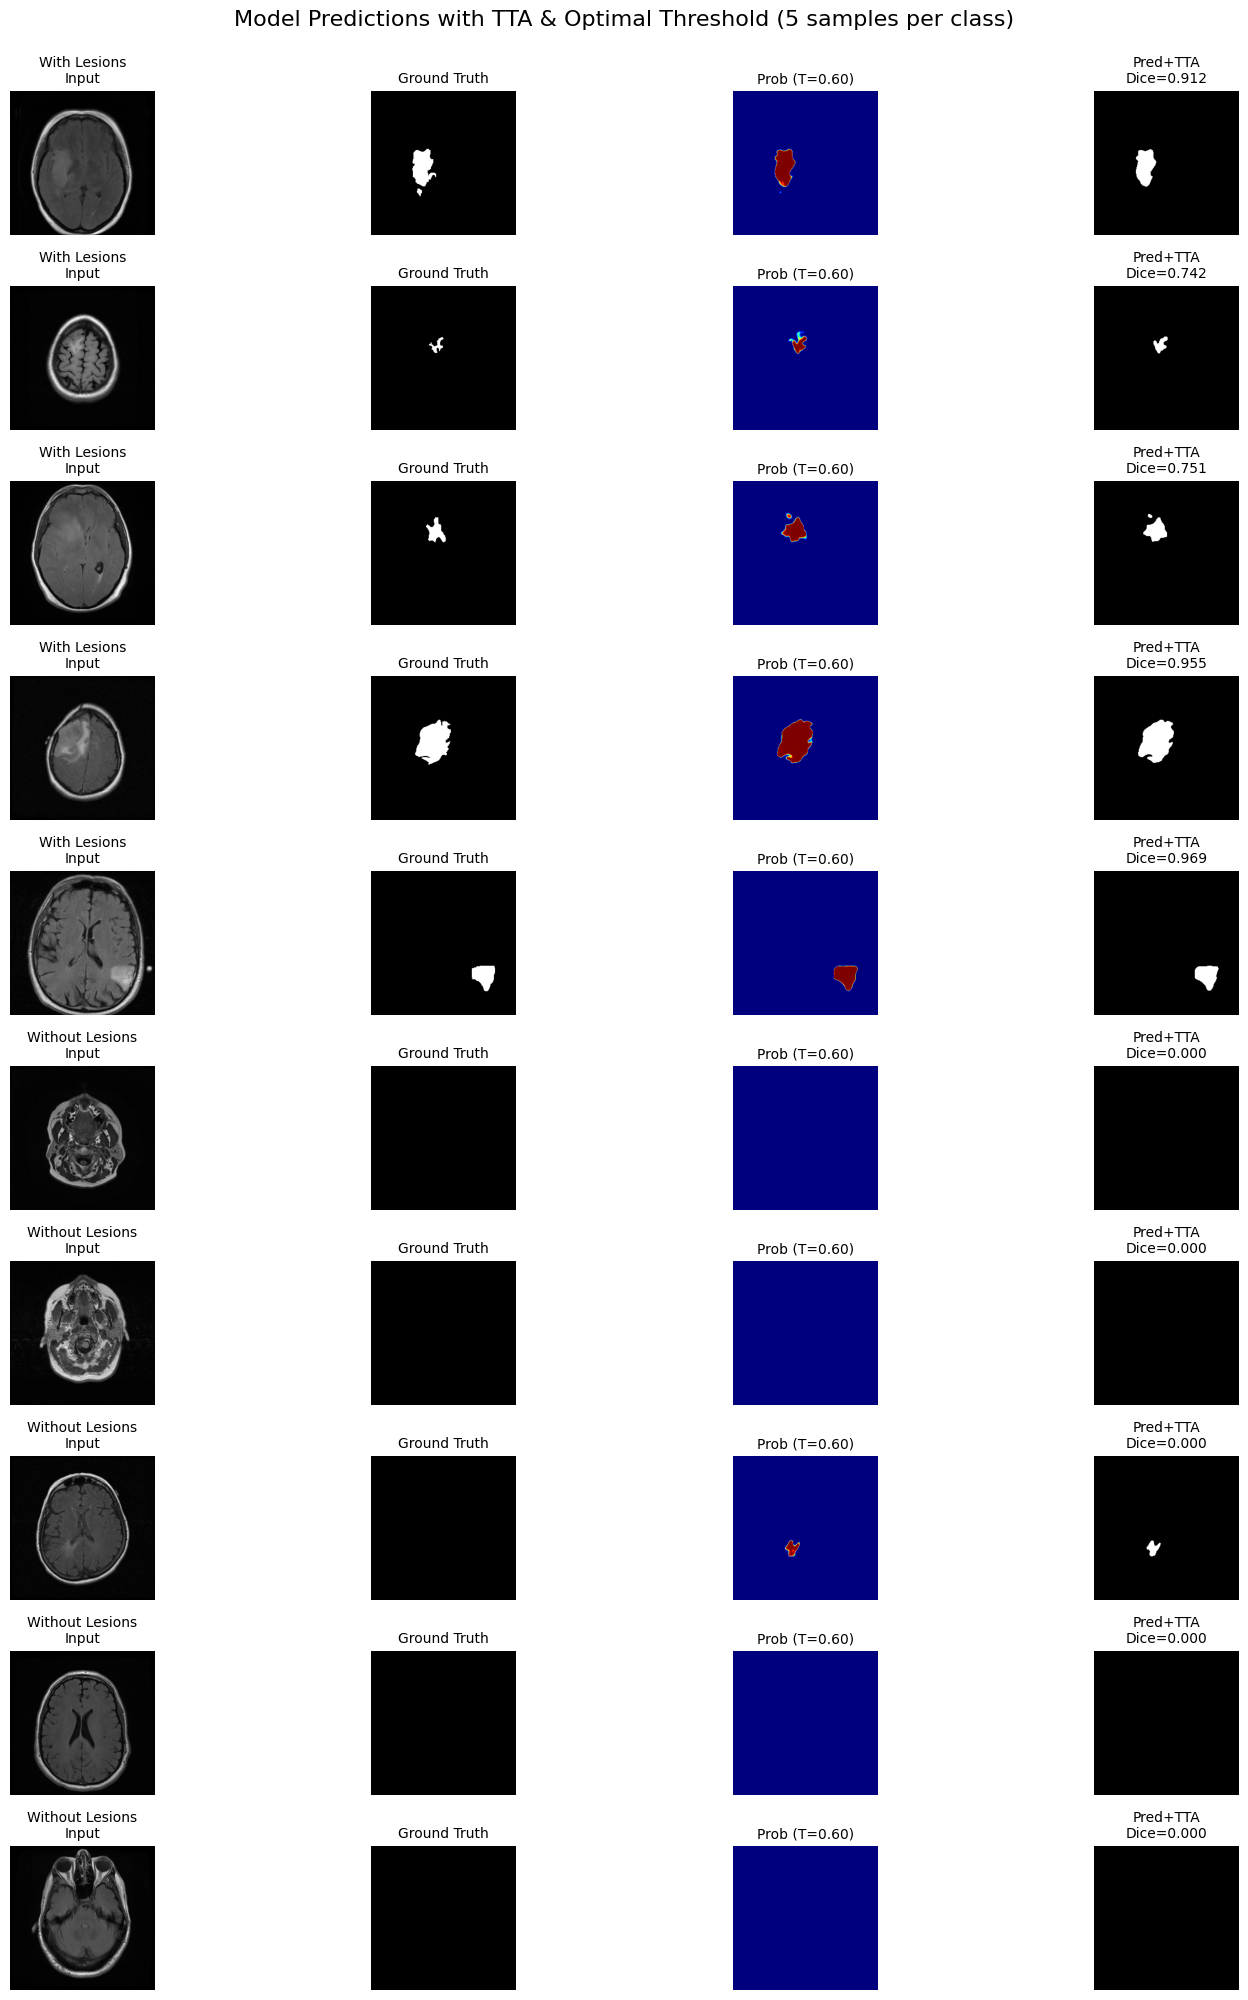

In [ ]:
# Load best model and visualize predictions
if best_model_path and os.path.exists(best_model_path) and val_loader is not None:
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Loaded best model: {os.path.basename(best_model_path)}")
    print(f"   Dice: {checkpoint['val_dice']:.4f}, IoU: {checkpoint.get('val_iou', 'N/A')}")
else:
    print("⚠️ No model checkpoint found - skipping predictions")

threshold = optimal_threshold if 'optimal_threshold' in locals() else 0.5
print(f"\n🎯 Using threshold: {threshold:.2f} for predictions")

if 'val_dataset' in locals() and len(val_dataset) > 0:
    # Get samples from each class (5 with lesions, 5 without)
    # Get validation set labels
    val_has_lesion = has_lesion[[valid_pairs.index(p) for p in val_pairs]] if 'val_pairs' in locals() and len(val_pairs) > 0 and len(has_lesion) > 0 else None

    if val_has_lesion is not None:
        positive_indices = np.where(val_has_lesion == 1)[0]
        negative_indices = np.where(val_has_lesion == 0)[0]
        
        np.random.seed(config.SEED)
        n_per_class = 5
        
        # Sample 5 from each class
        if len(positive_indices) >= n_per_class:
            pos_samples = np.random.choice(positive_indices, n_per_class, replace=False)
        else:
            pos_samples = positive_indices
        
        if len(negative_indices) >= n_per_class:
            neg_samples = np.random.choice(negative_indices, n_per_class, replace=False)
        else:
            neg_samples = negative_indices
        
        all_indices = list(pos_samples) + list(neg_samples)
        all_labels = ['With Lesions'] * len(pos_samples) + ['Without Lesions'] * len(neg_samples)
    else:
        # Fallback: random sampling if labels not available
        n_per_class = 5
        np.random.seed(config.SEED)
        all_indices = np.random.choice(len(val_dataset), min(n_per_class * 2, len(val_dataset)), replace=False)
        all_labels = ['Sample'] * len(all_indices)

    # Create figure: 10 rows (5 positive + 5 negative) x 6 columns
    # Columns: Input, Ground Truth, Input+GT Overlay, Prob Map, Pred Mask, Input+Pred Overlay
    fig, axes = plt.subplots(len(all_indices), 6, figsize=(24, len(all_indices) * 2))
    if len(all_indices) == 1:
        axes = axes.reshape(1, 6)

    for row, (idx, label) in enumerate(zip(all_indices, all_labels)):
        if idx < len(val_dataset):
            image, mask = val_dataset[idx]
            
            # Use TTA for more robust predictions
            if 'predict_with_tta' in globals():
                pred_prob, pred_binary = predict_with_tta(model, image, config.DEVICE, threshold=threshold)
            else:
                with torch.no_grad():
                    pred = model(image.unsqueeze(0).to(config.DEVICE))
                    pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
                    pred_binary = (pred_prob > threshold).astype(float)
            
            # Denormalize image for visualization
            if config.IN_CHANNELS == 1:
                img = image.squeeze().numpy()
                img = (img * 0.5) + 0.5  # Denormalize
            else:
                img = image.permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            mask_np = mask.squeeze().numpy()
            
            intersection = (pred_binary * mask_np).sum()
            sample_dice = 2 * intersection / (pred_binary.sum() + mask_np.sum() + 1e-6)
            
            # Column 1: Input
            axes[row, 0].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes[row, 0].set_title(f'{label}\nInput', fontsize=10)
            axes[row, 0].axis('off')
            
            # Column 2: Ground Truth mask
            axes[row, 1].imshow(mask_np, cmap='gray')
            axes[row, 1].set_title('Ground Truth', fontsize=10)
            axes[row, 1].axis('off')
            
            # Column 3: Input + Ground Truth overlay (translucent)
            axes[row, 2].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes[row, 2].imshow(mask_np, alpha=0.5, cmap='Reds')
            axes[row, 2].set_title('Input + GT Overlay', fontsize=10)
            axes[row, 2].axis('off')
            
            # Column 4: Probability map
            axes[row, 3].imshow(pred_prob, cmap='jet', vmin=0, vmax=1)
            axes[row, 3].set_title(f'Prob Map (T={threshold:.2f})', fontsize=10)
            axes[row, 3].axis('off')
            
            # Column 5: Predicted mask
            axes[row, 4].imshow(pred_binary, cmap='gray')
            axes[row, 4].set_title(f'Pred Mask\nDice={sample_dice:.3f}', fontsize=10)
            axes[row, 4].axis('off')
            
            # Column 6: Input + Predicted mask overlay (translucent)
            axes[row, 5].imshow(img, cmap='gray' if config.IN_CHANNELS == 1 else None)
            axes[row, 5].imshow(pred_binary, alpha=0.5, cmap='Blues')
            axes[row, 5].set_title('Input + Pred Overlay', fontsize=10)
            axes[row, 5].axis('off')

    title_suffix = f'({n_per_class} samples per class)' if val_has_lesion is not None else ''
    plt.suptitle(f'Model Predictions with TTA & Optimal Threshold {title_suffix}', fontsize=16, y=0.998)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'predictions_tta.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No validation dataset available for visualization")
